In [1]:
## Import library gb_mep
import gb_mep

In [2]:
## Load all required files after importing relevant libraries
import pickle
import numpy as np
import pandas as pd
santander_train = pd.read_csv('../data/santander_train.csv') 
santander_test = pd.read_csv('../data/santander_test.csv') 
santander_distances = np.load('../data/santander_distances.npy')
with open('../data/santander_dictionary.pkl', 'rb') as f:
    santander_dictionary = pickle.load(f)


In [3]:
santander_train

,start_id,end_id,start_time,end_time
0,722,131,0.483492,13.192747
1,531,460,0.484768,23.477447
2,515,603,0.624303,4.196019
3,804,689,0.807900,13.604670
4,740,48,1.568787,31.912915
...,...,...,...,...
6453258,302,637,241912.321072,241919.498489
6453259,740,342,241912.686823,241919.489431
6453260,327,324,241913.941339,241917.596443
6453261,224,337,241913.962367,241919.498538


In [4]:
G = gb_mep.gb_mep(df=santander_train, id_map=santander_dictionary, distance_matrix=santander_distances)


In [5]:
res = G.fit(x0=-np.ones(5), subset_nodes=range(20), start_times=False, end_times=True, distance_start=False, distance_end=False, thresh=1)
res2 = G.fit(x0=-np.ones(5), subset_nodes=range(20), start_times=True, end_times=False, distance_start=False, distance_end=False, thresh=1)

In [14]:
index = 10
pp = np.exp(res[index].x)
pp[2] += pp[1]
q = G.pvals_mep(params=pp, node_index=4)
pp = np.exp(res2[index].x)
pp[2] += pp[1]
q3 = G.pvals_sep(params=pp, node_index=4)
q2 = G.pvals_poisson_process(param=G.N[index]/G.T, node_index=4)

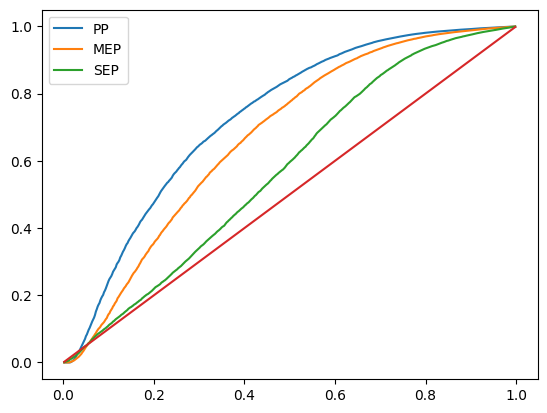

In [16]:
x = np.linspace(start=0, stop=1, num=501, endpoint=False)[1:]
y = np.percentile(a=q, q=x*100)
y2 = np.percentile(a=q2, q=x*100)
y3 = np.percentile(a=q3, q=x*100)
import matplotlib.pyplot as plt
plt.plot(x,y2,label='PP')
plt.plot(x,y,label='MEP')
plt.plot(x,y3, label='SEP')
plt.legend()
plt.plot(x,x)